### BIC3007 - *NGS Data Processing and Variant Calling*

# Analisis Variasi Genetik Menggunakan Data NGS

## Pengantar

Pada tutorial ini, kita akan melakukan pemrosesan data NGS (*short-read Amplicon Sequencing*) and melakukan pemanggilan variasi. Sampel DNA berasa dari ekstraksi pada jaringan darah manusia. DNA hasil ekstraksi kemudian dikirim untuk dilakukan NGS. Detail untuk pemrosesan sampel dapat dibaca pada publikasi [berikut](https://www.nature.com/articles/gim2016218#Sec2), tepatnya bagian *PCR amplification, pooling, library construction, and next-generation sequencing*.

Kita akan melakukan analisis pada gen HBA2 yang berasa dari dua sampel. Tutorial ini bertujuan untuk memperkenalkan alur pemrosesan data NGS dan *variant calling* dan *softwares/tools* yang dapat digunakan. Untuk detail terkait fungsi masing-masing langkah dan program yang digunakan, mohon untuk mempelajari secara mandiri.

Secara singkat, berikut alur kerja akan dilakukan
1. Buat indeks genom referensi untuk digunakan oleh bwa dan samtools
2. Sejajarkan sekuen dengan genom referensi
3. Ubah format pensejajaran menjadi *sorted BAM*
4. Hitung *read coverage* posisi pada genom
5. Deteksi polimorfisme nukleotida tunggal (SNP)
6. Filter dan laporkan varian SNP dalam VCF (variant calling format) 

Tutorial ini dibuat berdasarkan script yang dibuat oleh [Jason J Willian](https://jasonjwilliamsny.github.io/wrangling-genomics/02-variant-calling-workflow.html) dengan modifikasi. *Software/tools* yang kita gunakan disini tidak berada di lingkungan melainkan lingkungan terminal, sehingga disini kita menggunakan *shell scripting*. Untuk setiap command harus di *run* (*copy/paste*) ke terminal, atau dapat pula di run disini namun dengan sebelumnya menambahkan character "!" tepat sebelum setiap command.

 Sebagai contoh:

In [ ]:
! conda

Selalu ingat untuk menempatkan terminal ke *working directory*

In [ ]:
#run di terminal 
cd '/home/nailil/Documents/NGS data processing and variant calling' #silahkan ganti dengan lokasi working directory

## Installation

Sebelumnya kita perlu menginstal *softwares/tools* yang akan digunakan. *Copy/paste* command di bawah ke terminal, satu per satu. 

In [ ]:
#run di terminal
conda install -c bioconda bwa #install bwa dari biocaonda
conda install -c bioconda samtools #install samtools
conda install -c bioconda bcftools #install bcftools

Kita juga perlu mengistal *Integrative Genomics Viewers* (IGV) untuk membantu visualisasi hasil pemetaan dan/atau pensejajaran. Silahkan akses laman [berikut](http://software.broadinstitute.org/software/igv/download) untuk mengunduh IGV sesuai versi OS, atau bisa juga dengan *copy/paste* dan *run* command berikut di terminal.

In [ ]:
#run di terminal
sudo apt install igv 

Selanjutnya, kita akan buat *directory* untuk setiap file output untuk mempermudah akses. 

In [ ]:
! mkdir -p results/sai
! mkdir -p results/sam
! mkdir -p results/bam
! mkdir -p results/bcf
! mkdir -p results/vcf
! mkdir -p data/ref_genome #folder untuk genom referensi

## Download Genom Referensi

Referensi Genom manusia dapat diunduh pada laman [*Genome Browser Gateway*](https://genome-asia.ucsc.edu/cgi-bin/hgGateway?redirect=manual&source=genome.ucsc.edu) dari *Genomics Instutite UCSC*. Kita akan mengunduh sekuen beserta anotasi nya menggunakan http. Pada tutorial ini, kita hanya akan mengunduh sekuen genom kromosom 16 (lokasi gen HBA). Kita bisa mengunduh secara langsung pada [laman](http://hgdownload.soe.ucsc.edu/goldenPath/hg19/chromosomes/) (pilih chr16) dan memindahkan secara manual ke folder data/ref_genome, atau dengan menggunakan command dibawah. 

In [ ]:
! wget http://hgdownload.soe.ucsc.edu/goldenPath/hg19/chromosomes/chr16.fa.gz #unduh Ref Genome chr16
! mv chr16.fa.gz data/ref_genome/ #pindah ref genom ke folder data

## Indeksasi Genom Referensi 

Anda tidak dapat melakukan pemetaan secara langsung pada file .fasta, sehingga kita perlu mengindeks file genom referensi terlebih dahulu. Kita melakukan indeksasi untuk bwa dan samtools. Secara sederhana, *genome indexing* dapat artikan sebagai suatu bentuk pemrosesan untuk memampatkan ukuran dari text/informasi sehingga mempercepat suatu pencarian, dalam hal ini pemetaan sekuen. 

Command indeksasi genom dengan bwa. Silahkan baca detail command bwa [disini](http://bio-bwa.sourceforge.net/bwa.shtml).

In [ ]:
! bwa index -p chr16bwaidx -a bwtsw data/ref_genome/chr16.fa.gz #indeksasi genom
! mv chr16* data/ref_genome #pindah file ke folder reference

Command indeksasi genom dengan bwa. Silahkan baca detail command samtools [disini](http://www.htslib.org/doc/samtools.html).

In [ ]:
! gzip -d  data/ref_genome/chr16.fa.gz #unzip .fa.gz menjadi .fa
! samtools faidx data/ref_genome/chr16.fa #buat indeks (.fa.fai)

## Pensejajaran sekuen dengan genom referensi

Kita lakukan pensejajaran bacaan-pendek (*short-reads*) ke genom referensi. Disini kita melakukan pemetaan sekuen forward/reverse ke genom referensi yang sudah kita indeks. Kita akan menghasilkan output dengan format SAI yang selanjutnya akan kita gabung convert bersama *paired-end* nya (forward dan reverse nya) menjadi format SAM. 

Command pensejajaran untuk sekuen dari masing-masing primer.  

In [ ]:
#Sampel 1
! bwa aln -t 4 data/ref_genome/chr16bwaidx data/trimmed_fastq/1_HBA2_1.fq.gz > 1_HBA2_1.sai #align bacaan forward primer dri sampel 1
! bwa aln -t 4 data/ref_genome/chr16bwaidx data/trimmed_fastq/1_HBA2_2.fq.gz > 1_HBA2_2.sai #align bacaan reverse primer dri sampel 1
! mv *.sai results/sai/ #pindah output .sai ke folder result

Silahkan tulis command untuk sampel yang kedua, 

In [ ]:
#Sampel 2


Selanjutnya, kita gabungkan pembacaan forward dan reverse (*paired-end*) lalu kita konversi ke format SAM

In [ ]:
#Sampel 1
! bwa sampe data/ref_genome/chr16bwaidx results/sai/1_HBA2_1.sai results/sai/1_HBA2_2.sai data/trimmed_fastq/1_HBA2_1.fq.gz data/trimmed_fastq/1_HBA2_2.fq.gz > 1_HBA2.sam #konversi ke SAM
! mv *.sam results/sam #pindah output .sam ke folder result

Silahkan tulis command untuk sampel yang kedua, 

In [ ]:
#Sampel 2, 


Note: Sequence Alignment Map (SAM) adalah format berbasis text yang digunakan untuk menyimpan pensejajaran sekuen biologi ke sekuen referensinya. Format SAM dan samtools dikembangkan [Heng Li and Bob Handsaker et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2723002/) Isi dari file SAM dapat langsung dilihat dibaca oleh manusia namun tidak sulit untuk dibaca dan diproses komputer. Untuk memungkinkan pemrosesan sekuen dengan program komputer kita perlu menkonversi SAM file ke BAM file. 

Lihat sebagian output file SAM:

In [ ]:
! cat results/sam/1_HBA2.sam | head

## Konversi SAM ke (sorted) BAM

Binary Alignment Map (BAM) adalah representasi format SAM dalam bentuk binary yang terkompresi. File dengan format ini, tidak dapat dibaca manusia, untuk dapat membaca isinya kita perlu membukanya dengan software/tools. Format BAM diperlukan untuk analisis dengan software/tools yang umumnya hanya menerima input berupa text [binary](https://en.wikipedia.org/wiki/Binary_code). setelah konversi, kita juga akan melakukan *sorting* dan *indexing*. BAI file diperlukan untuk visualisasi dengan IGV.

Command untuk konversi ke BAM, *sorting* BAM dan buat indeks BAM (BAI)

In [ ]:
#Sampel 1
! samtools view -bS results/sam/1_HBA2.sam > 1_HBA2.bam #konversi SAM ke BAM
! samtools sort 1_HBA2.bam -o 1_HBA2_sorted.bam #sort BAM file
! samtools index 1_HBA2_sorted.bam #buat indeks BAM 
! mv *.bam *.bai results/bam #pindah output .bam dan .bai ke folder result

Silahkan tulis command untuk sampel yang kedua, 

In [ ]:
#Sampel 2


### Visualisasi pemetaan dengan IGV

Sampai, sini kita sudah mendapatkan hasil pemetaan sekuen-pendek (*sort-reads*) ke genom referensi. Kita bisa melihat secara langsung visualisasi pemetaannya melalui IGV. Silahkan buka aplikasi IGV dengan mengetik IGV di terminal atau run [! igv] disini. 

In [ ]:
! igv

1. Load file 
File ==> Load from file ... (silahkan pilih file sorted.bam)
2. Atur referensi
Pilih chr16, pada bar di samping chr16 silhkan tulis **chr16:222,500-228,000** untuk menunjukkan tepat lokasi gen HBA

Kita bisa menyesuaikan ukuran tampilan dengan mengubah menu bar pada kanan atas. 

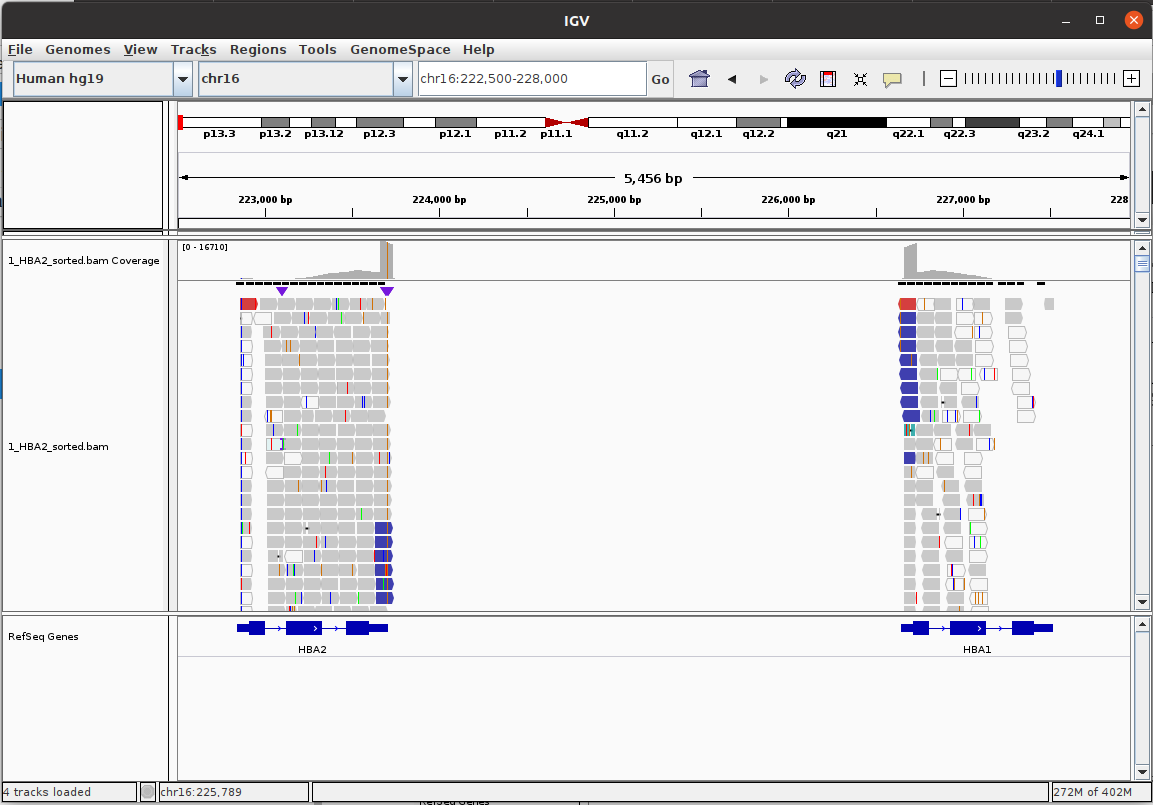

## Menghitung *read coverage* posisi pada genom

BCFtools adalah program untuk memanggil dan memanipulasi file dalam Variant Call Format (VCF) dan bentuk binary nya (BCF). Silahkan baca detail mengenai bcftools [disini](http://samtools.github.io/bcftools/bcftools.html). Untuk pemanggilan variasi, mula-mulai kita akan menghitung *read coverage* menggunakan bcftools. Selain, itu kita juga akan menandai posisi variasi (posisi sekuen sampel yang berbeda dengan sekuen referensi). Output dari proses penambahan kedua informasi tersebut adalah file dalam format BCF.

In [ ]:
#Sampel 1
! bcftools mpileup -O b -o 1_HBA2_raw.bcf -f data/ref_genome/chr16.fa results/bam/1_HBA2_sorted.bam #hitung read coverage dan tandai variasi
! mv *.bcf results/bcf #pindah output .bcf ke folder result

Silahkan tulis command untuk sampel yang kedua, 

In [ ]:
#Sampel 2


## Deteksi polimorfisme nukleotida tunggal (SNP)

Selanjutnya kita akan melakukan pemanggilan variasi yang sebelumnya sudah ditandai. Dengan menjalankan command dibawah kita akan memperoleh posisi dan jenis variasi beserta informasi lainnya, seperti *quality*.

In [ ]:
#Sampel 1
! bcftools call --ploidy 1 -m -v -o 1_HBA2_variants.vcf results/bcf/1_HBA2_raw.bcf #pemanggilan variasi
! mv *.vcf results/vcf #pindah output .vcf ke folder result

Silahkan tulis command untuk sampel yang kedua, 

In [ ]:
#Sampel 2


## Filter dan laporkan varian SNP dalam VCF (variant calling format) 

Terakhir, kita melakukan filter untuk memperoleh variasi terakhir. 

In [ ]:
#Sampel 1
! vcfutils.pl varFilter results/vcf/1_HBA2_variants.vcf  > 1_HBA2_final_variants.vcf #pemanggilan variasi
! mv *.vcf results/vcf #pindah output .vcf ke folder result

Silahkan tulis command untuk sampel yang kedua, 

In [ ]:
#Sampel 2


### Lihat variasi pada VCF format

Silahkan run command berikut untuk melihat khusus pada bagian variasi yang terpanggil,

In [ ]:
! cat results/vcf/2_HBA2_final_variants.vcf | grep -A10 '#CHROM' 

Untuk memahami masing-masing header silahkan baca laman tepatnya pada [*Explore the VCF format*](https://datacarpentry.org/wrangling-genomics/04-variant_calling/index.html)

## Alur kerja pemrosesan data NGS dan pemanggilan variasi

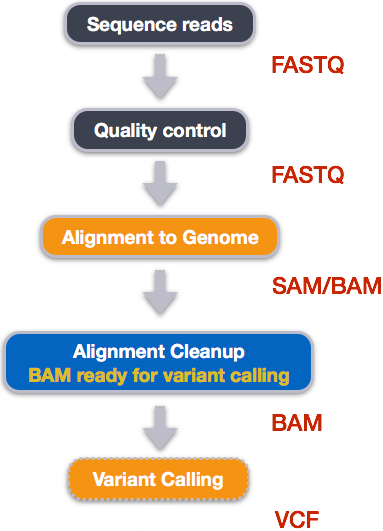

## Post-test / Assignment

Harap mengumpulkan,

1. Screenshot visualisasi pemetaan short-read sampel 2 di IGV
2. Lokasi dan jenis variasi akhir pada sampel 2, beserta nilai quality nya
3. Screenshot visualisasi variasi sampel 1 dan sampel 2 di IGV, bagaimana variasi di kedua sampel? (bonus)
4. Bagaimana pengaruh variasi tersebut terhadap ekspresi gen HBA2? (bonus)